# FOOF: BJH016

In [9]:
import matplotlib
# matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
from tabulate import tabulate
import IPython
import seaborn as sns

# Import required code for visualizing example models
from fooof import FOOOF
from fooof import FOOOFGroup
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.plts.spectral import plot_power_spectra

In [3]:
## Prep paths ##

subject = 'BJH016'
orig_data_fi = '/home/brooke/knight_server/remote/WashU/data/PacmanTask/BJH016/PacmanTask/ECOGS001R01.dat'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}/behave"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [4]:
## Load Data ##

# Load raw, clean data
bp_raw_clean_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_raw_clean_data.fif")

# Load Data in Mem
brc_data = bp_raw_clean_fif.get_data(reject_by_annotation = 'omit')

Opening raw data file /home/brooke/pacman/preprocessing/BJH016/ieeg/BJH016_bp_raw_clean_data.fif...
    Range : 0 ... 2077999 =      0.000 ...  1038.999 secs
Ready.
Opening raw data file /home/brooke/pacman/preprocessing/BJH016/ieeg/BJH016_bp_raw_clean_data-1.fif...
    Range : 2078000 ... 4155999 =   1039.000 ...  2077.999 secs
Ready.
Opening raw data file /home/brooke/pacman/preprocessing/BJH016/ieeg/BJH016_bp_raw_clean_data-2.fif...


/tmp/ipykernel_2040613/346034315.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH016/ieeg/BJH016_bp_raw_clean_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_raw_clean_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_raw_clean_data.fif")


    Range : 4156000 ... 5901899 =   2078.000 ...  2950.950 secs
Ready.
Omitting 331868 of 5901900 (5.62%) samples, retaining 5570032 (94.38%) samples.


In [5]:
## Dictionary of electrode locations ##

hc_type = ['mid_r', 'mid_r', 'mid_r', 'mid_r', 'mid_r', 'post_l', 'post_l', 'post_l', 'HL1', 'HL2', 'HL3', 'mid_l', 'mid_l', 'mid_l'],


ROIs = {
    'hc'     :['OR3', 'OR4', 'OR5', 'OR6', 'OR7', 'IL2', 'IL3', 'IL4', 'HL1', 'HL2', 'HL3', 'HL4', 'HL5', 'HL6'],
    'ofc'    :['AL1', 'AL2', 'AL3', 'AL4', 'AL5', 'AL6', 'AL7', 'AL8', 'AL9', 'AL10', 'AL11', 'AL12'],
    'amyg'   :['GL2', 'GL3', 'GL4', 'GL5', 'GL6'],
    'insula' :['BL1', 'BL2', 'BL3', 'BL4', 'BL5',  'BL6', 'BL7', 'BL8', 'BL9', 'LL1', 'LL2', 'LL3', 'LL4'],
    'cing'   :['CL1', 'CL2', 'CL3', 'CL4']
}

hc_list = []
hc_indices = []
ofc_list = []
ofc_indices = []
amyg_list = []
insula_list = []
cing_list = []
pairs_long_name = [ch.split('-') for ch in bp_raw_clean_fif.info['ch_names']]
bidx = len(bp_raw_clean_fif.info['bads']) +1
pairs_name = pairs_long_name[bidx:len(pairs_long_name)]

for ix in range(1, len(pairs_name)):
    if pairs_name[ix][0] in ROIs['hc'] or pairs_name[ix][1] in ROIs['hc']:
        hc_list.append(pairs_name[ix])
        hc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['ofc'] or pairs_name[ix][1] in ROIs['ofc']:
        ofc_list.append(pairs_name[ix])
        ofc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['amyg'] or pairs_name[ix][1] in ROIs['amyg']:
        amyg_list.append(pairs_name[ix])
    if pairs_name[ix][0] in ROIs['insula'] or pairs_name[ix][1] in ROIs['insula']:
        insula_list.append(pairs_name[ix])
    if pairs_name[ix][0] in ROIs['cing'] or pairs_name[ix][1] in ROIs['cing']:
        cing_list.append(pairs_name[ix])
        


In [6]:
hc_list

[['HL5', 'HL6'],
 ['HL6', 'HL7'],
 ['IL4', 'IL5'],
 ['OR2', 'OR3'],
 ['OR3', 'OR4'],
 ['OR4', 'OR5'],
 ['OR5', 'OR6'],
 ['OR6', 'OR7'],
 ['OR7', 'OR8']]

### Hippocampus

In [7]:
## calculate the power spectra ##

# setup
fs = 2000
brc_data_clean = brc_data[bidx:len(pairs_long_name), :]
hc_data_clean = brc_data_clean[hc_indices, :]

freqs, psds = compute_spectrum(hc_data_clean, fs, method='welch', avg_type='mean', nperseg=fs*2)

Running FOOOFGroup across 9 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/home/brooke/anaconda3/envs/ieeg_analysis/lib/python3.9/site-packages/fooof/plts/style.py:172: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                             Number of power spectra in the Group: 9                              
                                                                                                  
                        The model was run on the frequency range 2 - 50 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                              
                                                                                                  
          

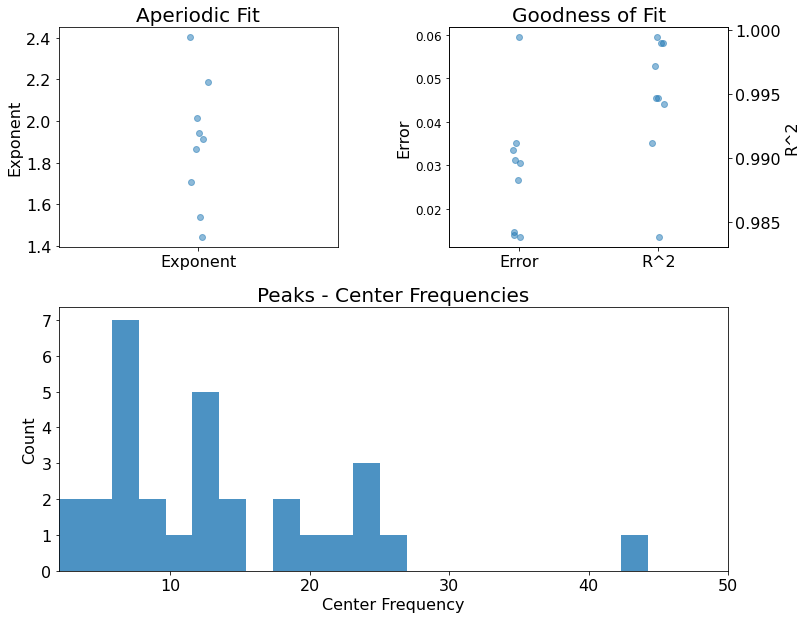

In [10]:
%matplotlib inline


# Initialize a FOOOF object
fm = FOOOFGroup()

# Set the frequency range to fit the model
freq_range = [2, 50]

# Report: fit the model, print the resulting parameters, and plot the reconstruction
fm.report(freqs, psds, freq_range)

In [46]:
peaks = fm.get_params('peak_params')

theta_peaks = peaks[peaks[:, 0] < 8, :]
peak_theta = theta_peaks[:, 0].mean()

len([hc_list[int(x)] for x in np.unique(theta_peaks[:, 3])])

# 8/9 electrodes had peaks in theta, mean freq was 5.6

theta_peaks

array([[4.19501386, 0.05112617, 1.21001343, 0.        ],
       [6.03408766, 0.26778665, 3.0947649 , 1.        ],
       [3.67162636, 0.24122939, 1.46002233, 2.        ],
       [6.065106  , 0.20914048, 2.66625125, 2.        ],
       [3.84873435, 0.10544132, 1.06259505, 4.        ],
       [7.42754029, 0.20698141, 2.55177244, 4.        ],
       [6.44749441, 0.49434021, 2.44308098, 5.        ],
       [6.3361323 , 0.44508835, 2.12642164, 6.        ],
       [4.90531436, 0.25750509, 1.57342048, 7.        ],
       [6.77487958, 0.54272128, 1.51284178, 7.        ],
       [6.67473786, 0.53609569, 1.68091624, 8.        ]])

### Indivudal foofing


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 50 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offs

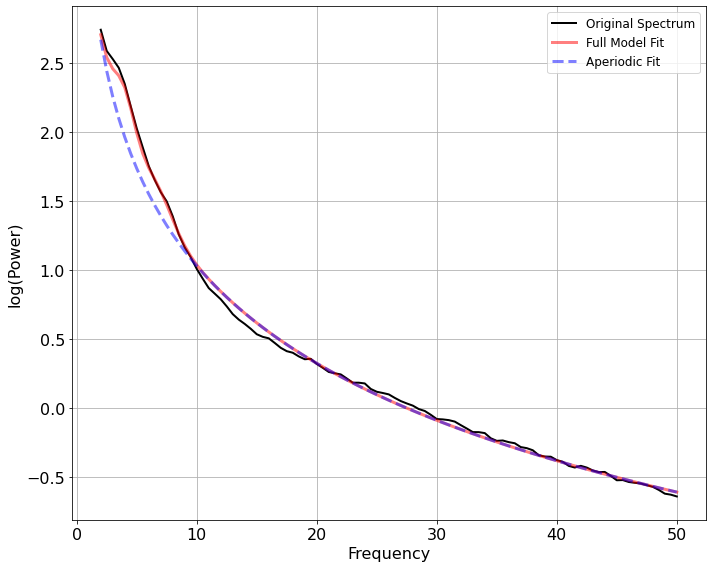

In [14]:
%matplotlib inline


# Initialize a FOOOF object
fm = FOOOF()

# Set the frequency range to fit the model
freq_range = [2, 50]

# Report: fit the model, print the resulting parameters, and plot the reconstruction
fm.report(freqs, psds[0], freq_range)

['HL5', 'HL6']

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 50 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic P

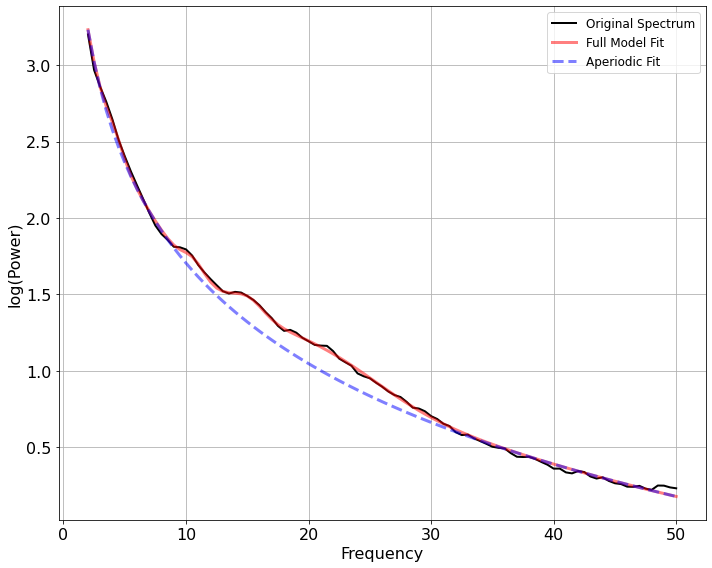

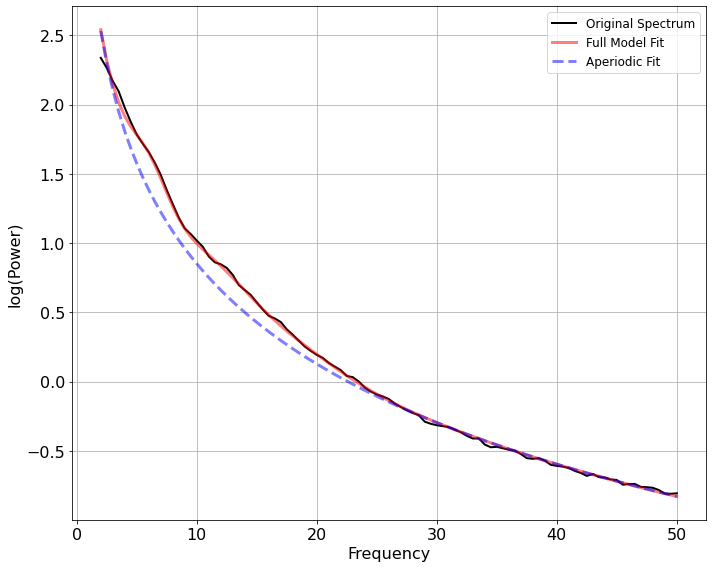

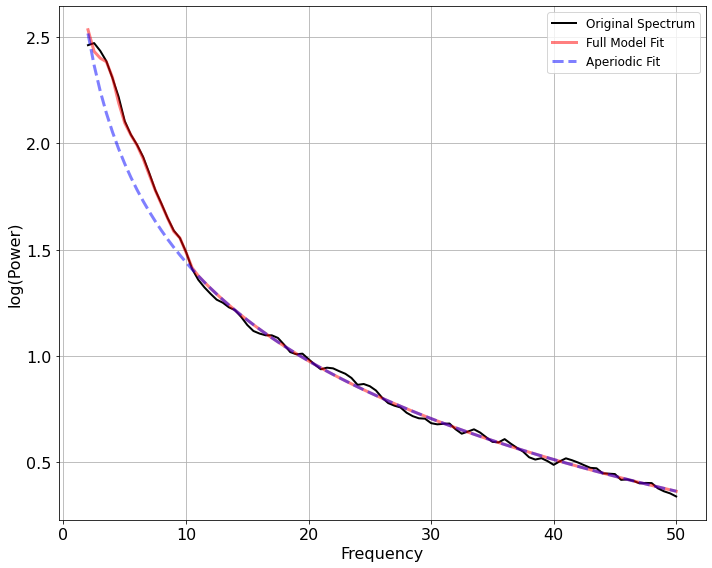

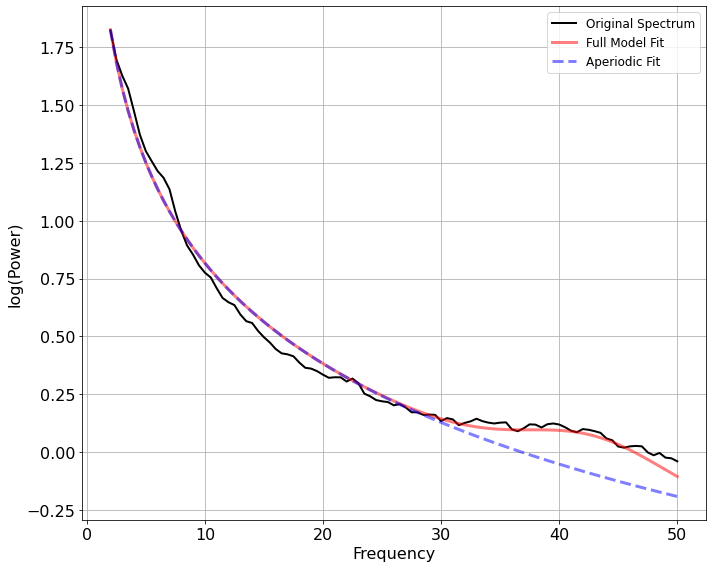

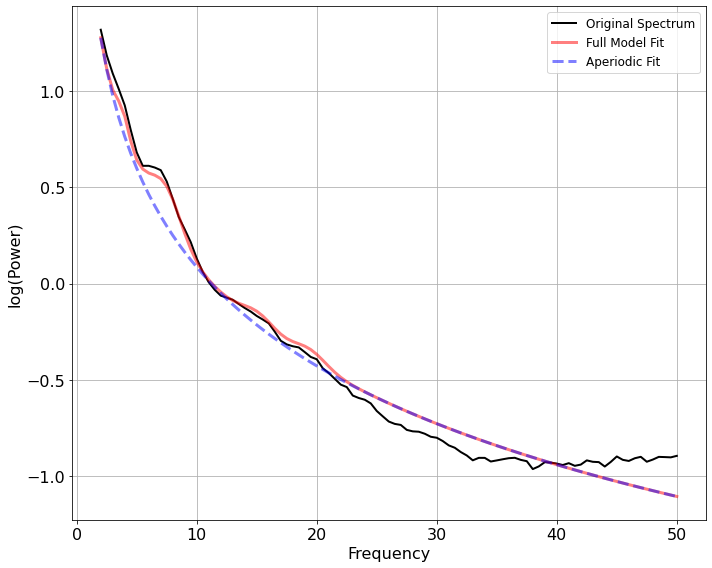

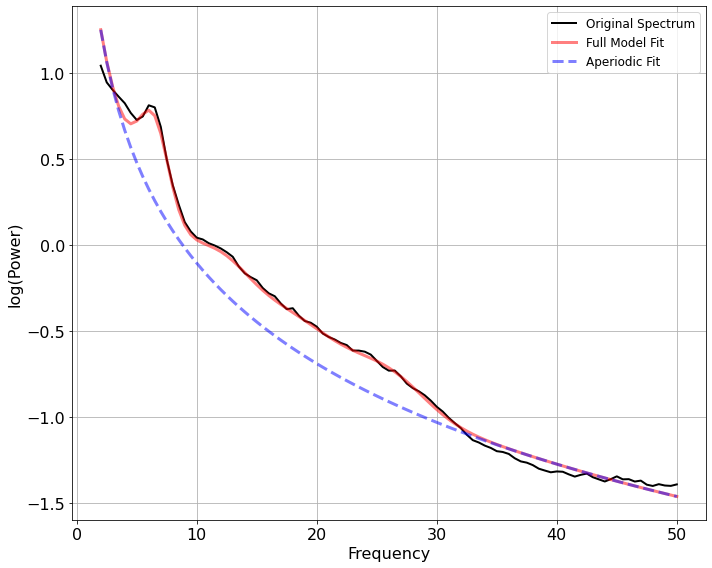

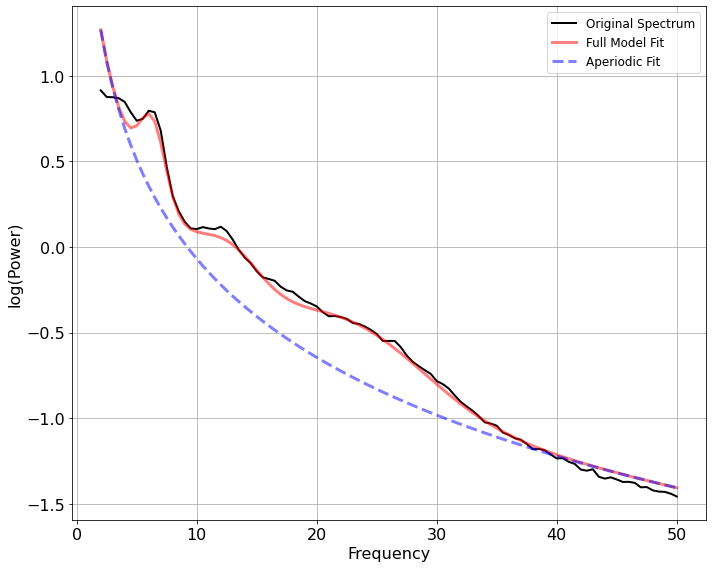

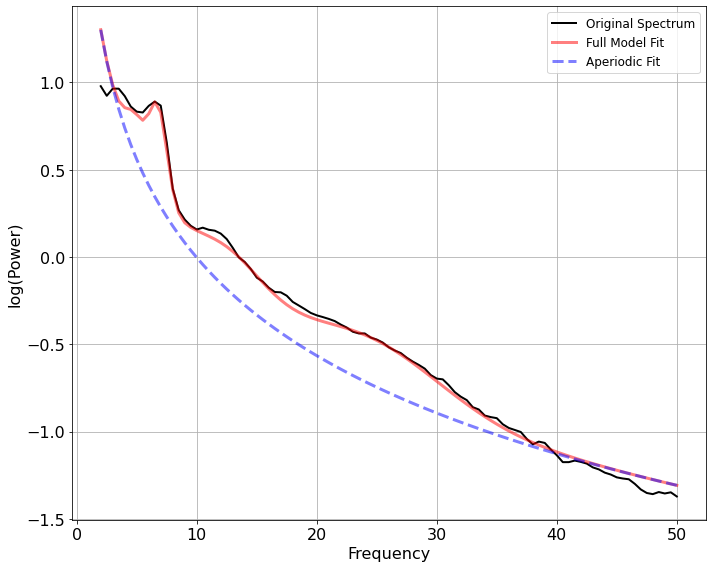

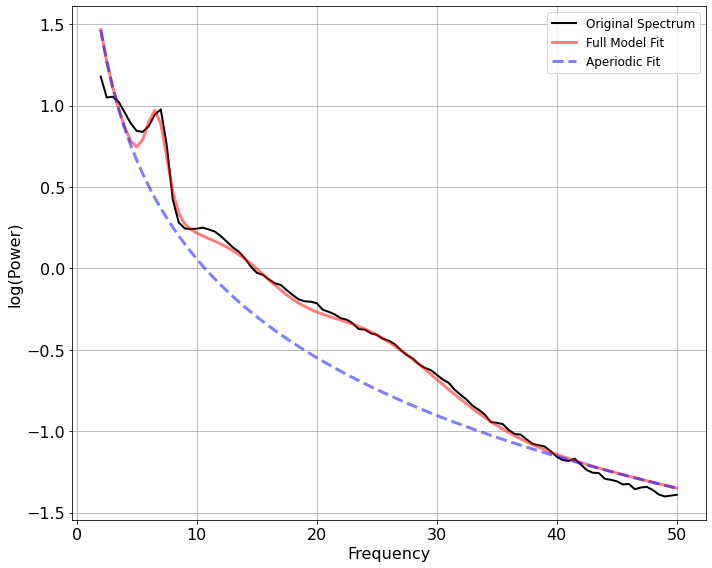

In [8]:
%matplotlib inline

for idx in range(hc_data_clean.shape[0]):
    # print name
    print(hc_list[idx])

    # Initialize a FOOOF object
    fm = FOOOF()

    # Set the frequency range to fit the model
    freq_range = [2, 50]

    # Report: fit the model, print the resulting parameters, and plot the reconstruction
    fm.report(freqs, psds[idx], freq_range)

## results

So it looks like the there are three peaks, with one in the theta range, from 2-6Hz for elec HL5-HL6

### OFC

In [12]:
## calculate the power spectra ##

# setup
fs = 2000
brc_data_clean = brc_data[bidx:len(pairs_long_name), :]
hc_data_clean = brc_data_clean[ofc_indices, :]

freqs, psds = compute_spectrum(hc_data_clean, fs, method='welch', avg_type='mean', nperseg=fs*2)


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 50 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offs

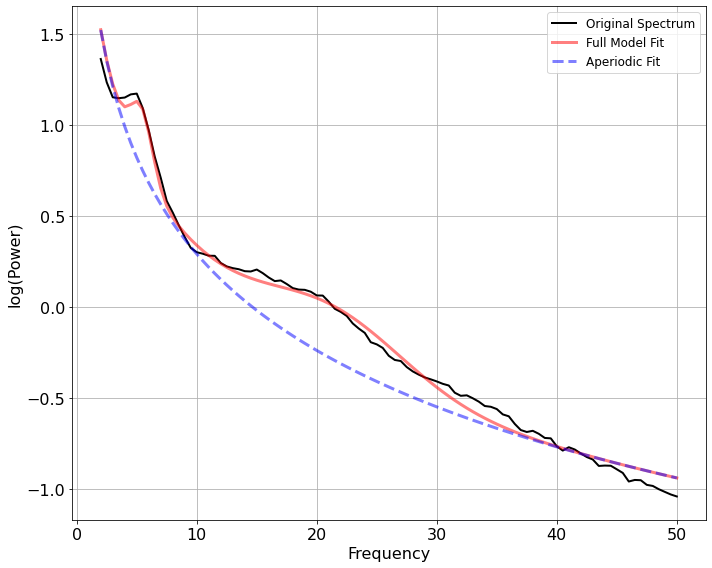

In [13]:
%matplotlib inline


# Initialize a FOOOF object
fm = FOOOF()

# Set the frequency range to fit the model
freq_range = [2, 50]

# Report: fit the model, print the resulting parameters, and plot the reconstruction
fm.report(freqs, psds[7], freq_range)


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 50 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offs

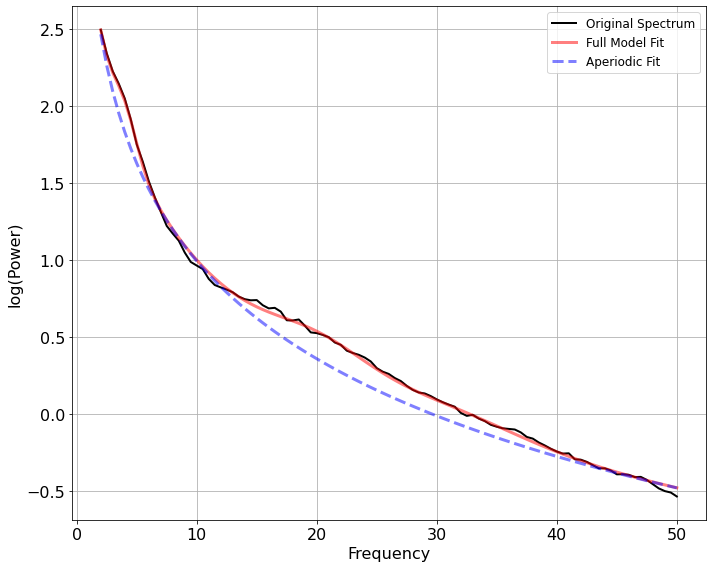

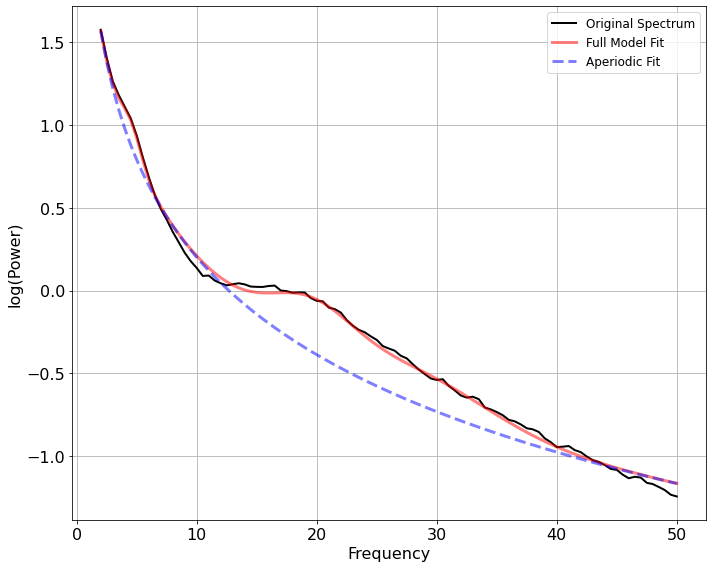

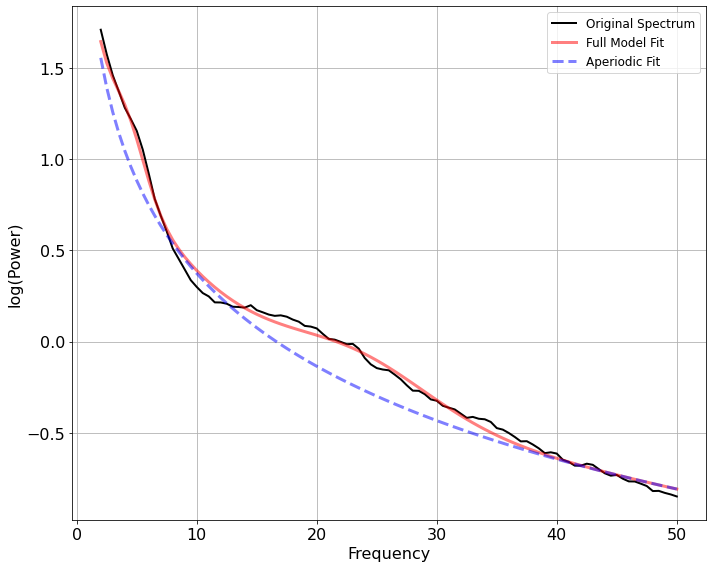

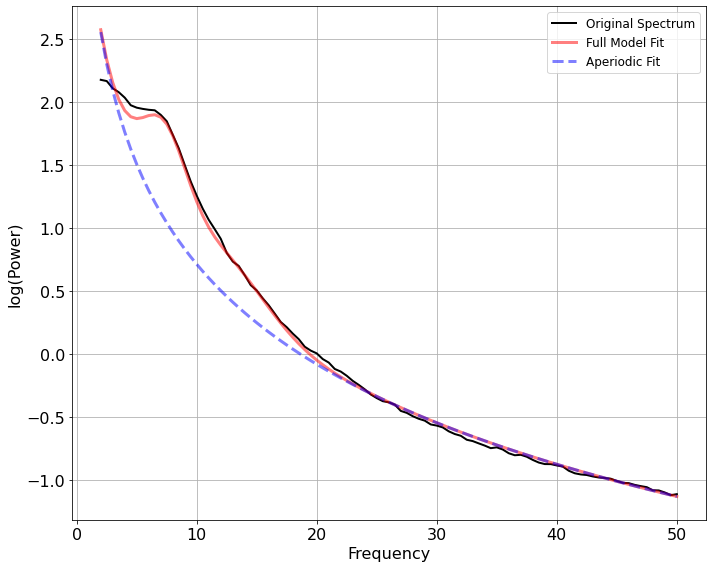

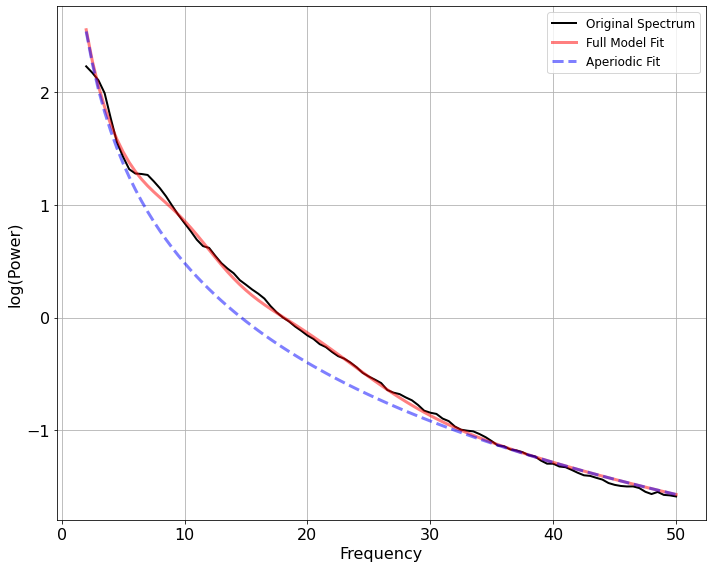

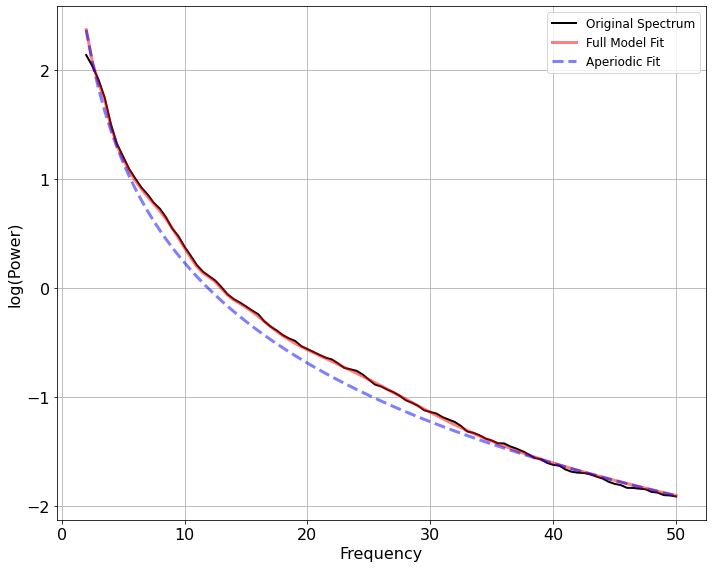

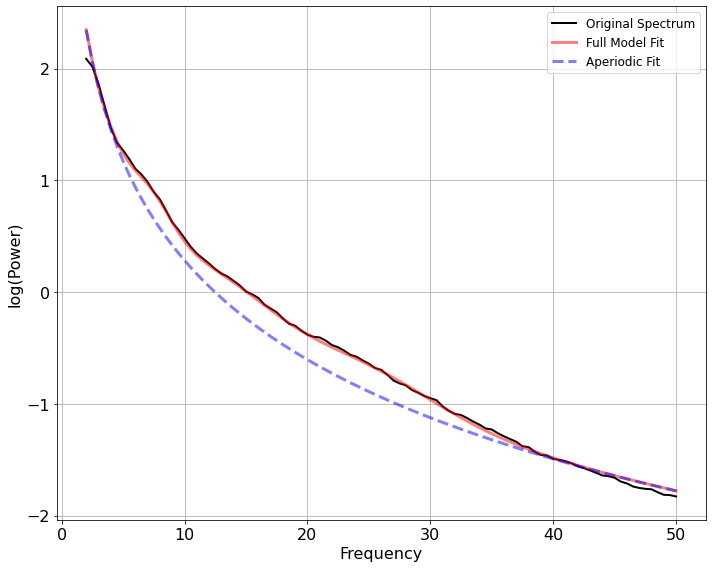

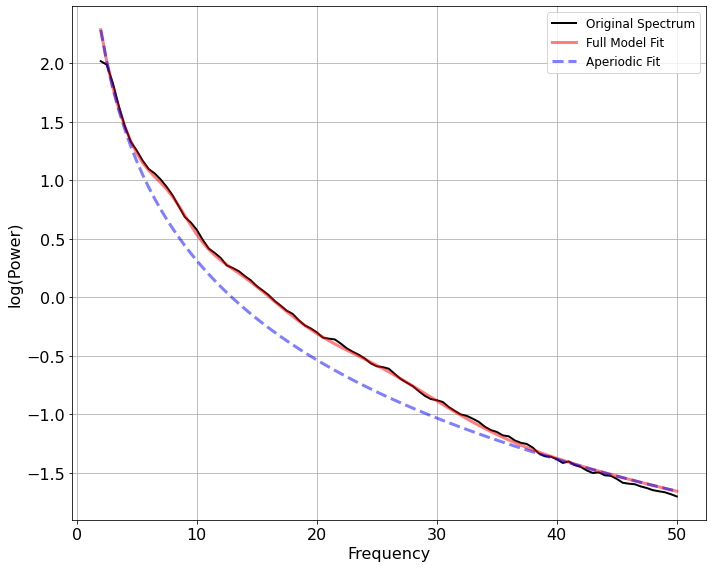

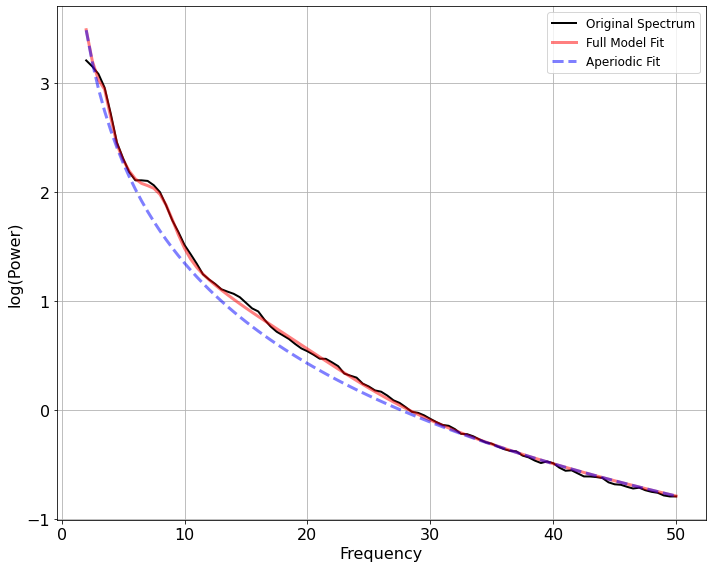

In [18]:
%matplotlib inline

for idx in range(hc_data_clean.shape[0]):

    # Initialize a FOOOF object
    fm = FOOOF()

    # Set the frequency range to fit the model
    freq_range = [2, 50]

    # Report: fit the model, print the resulting parameters, and plot the reconstruction
    fm.report(freqs, psds[idx], freq_range)